# FYP-DL: LogReg - Countering Imbalance via Class Weights

In this notebook, I'm going to use class weights to try and improve my model's ability to identify TP and TN examples over FP and FNs using class weights. 

Specifically, I will test this with logistic regression. 

In [51]:
# For loading data from Drive
from google.colab import drive, files

# Standard Imports
import pandas as  pd
import os 
import numpy as np

# Sklearn - Model Selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split 

# Sklearn - Model Evaluation 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, \
plot_confusion_matrix, plot_roc_curve

# Sklearn - Logistic Regression
from sklearn.linear_model import LogisticRegression

# Sklearn - Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Random Number Seeding
np.random.seed(0)

In [52]:
def get_classification_result(estimator, X, y_true, classifier_name=None,
                              normalize_conf_mat='all'):
    """Custom function to display classification results"""
    # Predictions will be used several times
    y_pred = estimator.predict(X) 

    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves'],))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    if (normalize_conf_mat=='rows'):
      normalize='true'
    elif (normalize_conf_mat=='cols'):
        normalize='pred'
    else:
      normalize=normalize_conf_mat

    # Use built-in function to get confusion matrix for this estimator
    conf_mat_display = plot_confusion_matrix(estimator=estimator, 
                                             X=X, 
                                             y_true=y_true, 
                                             labels=[0, 1],
                                             normalize=normalize, 
                                             display_labels=['Regular Consumers', 'Thieves'], 
                                             cmap=plt.cm.Blues)
    
    # Add a title (with optional classifier name)
    conf_mat_display.ax_.set_title("Confusion Matrix - {}".format(
        classifier_name if classifier_name is not None 
        else 'Test Classifier' ))
    
    # This will render the confusion matrix as an image
    print(conf_mat_display.confusion_matrix);
    plt.grid(False)       # Remove extra lines from confusion matrix

    roc_curve_display = plot_roc_curve(estimator, X, y_true)
    roc_curve_display.ax_.set_title('ROC Curve' +
                                    ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                    fontsize=18);

# Importing Modules

In [53]:
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/build_WDNN.py"

# Loading Data

In [54]:
# Mount Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [55]:
# Defining filepaths
ROOT_DIR = "/content/drive/My Drive"
FYP_DIR = "EE 16-17 FYP DL Energy Theft Detection"
DATA_DIR = "Data/full-processing-data"
FILE_NAME = "outliersRemoved.csv"

# Create filepath
FILE_PATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, FILE_NAME)

In [56]:
# Print the filepath for checking
print(FILE_PATH)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv


In [57]:
# Read in the data
df = pd.read_csv(FILE_PATH)

In [58]:
# Did it work 
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Train Test Split

In [59]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [60]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

# Feature Scaling Pipeline

In [62]:
# Import the pipeline functions from the pipeline modules
from pipelines import get_pipeline_1D, get_pipeline_2D

# Creating pipeline objects
pipeline_1D = get_pipeline_1D(scaling_strategy='Standard')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D = pipeline_1D.fit_transform(X_train_val)
X_train_1D = pipeline_1D.fit_transform(X_train)
X_val_1D = pipeline_1D.fit_transform(X_val)
X_test_1D = pipeline_1D.fit_transform(X_test)

# Inspecting Feature Distributions

In [63]:
from seaborn import distplot
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def plot_feature_distributions(features, title_str=''):
  plt.figure(figsize=(12, 6))
  distplot(features.ravel(), kde=False, bins=100, hist_kws={'linewidth': 2, 'edgecolor': 'k'})
  plt.xlabel('Feature Values', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  plt.title('Feature Distribution Plot' + title_str, fontsize=18)

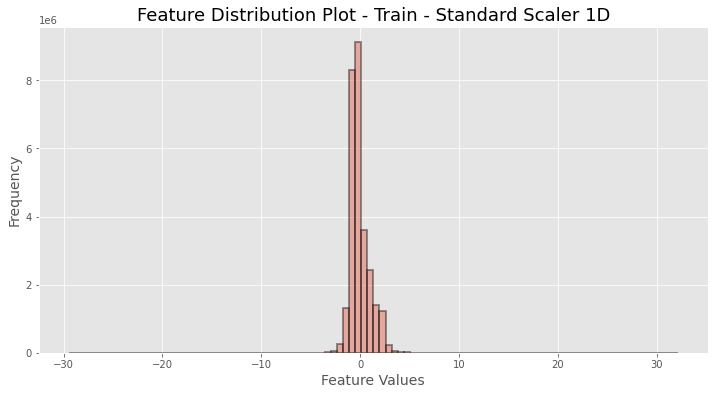

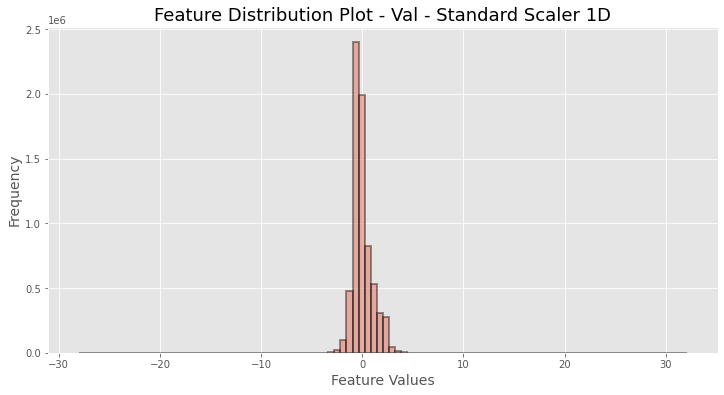

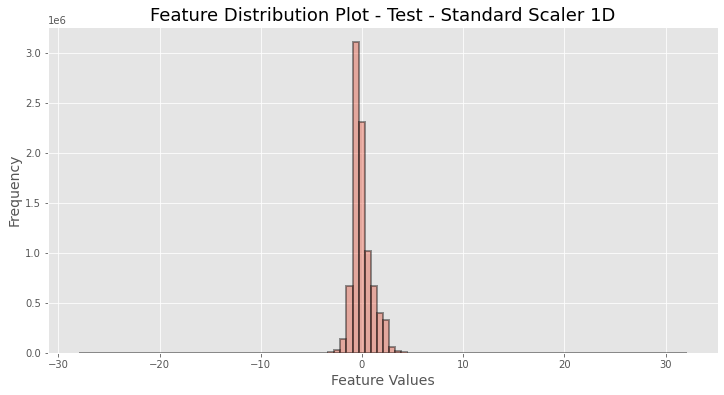

In [14]:
plot_feature_distributions(X_train_1D, ' - Train - Standard Scaler 1D')
plot_feature_distributions(X_val_1D, ' - Val - Standard Scaler 1D')
plot_feature_distributions(X_test_1D, ' - Test - Standard Scaler 1D')

# Class Distributions

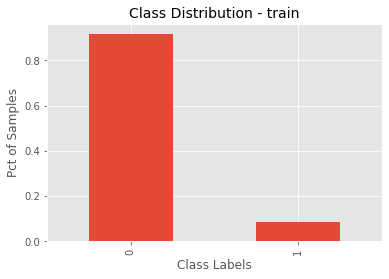

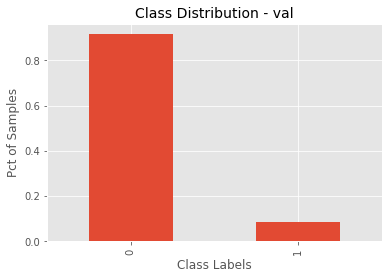

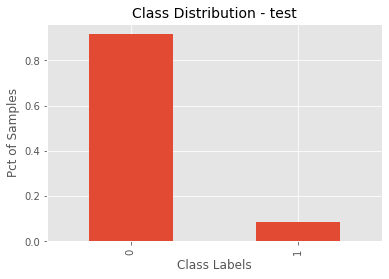

In [15]:
for (name, y) in {'train': y_train, 'val': y_val, 'test': y_test}.items():
  plt.figure()
  df_tmp = pd.DataFrame(y)['FLAG'].value_counts(normalize=True)
  df_tmp.plot(kind='bar')
  plt.title('Class Distribution - ' + name, fontsize=14)
  plt.xlabel('Class Labels', fontsize=12)
  plt.ylabel('Pct of Samples', fontsize=12)

# Class Weights 01 - `sklearn` API

Instead of figuring out a ratio of `n_pos` to `n_neg` manually and using them to set loss weights, I will use `sklearn`'s `compute_class_weight` method. 

I will be computing these weights using the `train` data, not `train_val` so as not to create a data leak.

In [16]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train_val
)

# Create a dictionary that can be passed to an `sklearn` estimator
cw_sklearn = dict(zip([0, 1], class_weights))

# Output this: does it make sense?
cw_sklearn

{0: 0.5466376390904693, 1: 5.860477178423237}

# Logistic Regression - Zheng

In [ ]:
# Instantiate
logRegZheng = LogisticRegression(penalty='l2', 
                                 C=1.0, 
                                 random_state=0, 
                                 class_weight=cw_sklearn, 
                                 max_iter=500, 
                                 verbose=1, 
                                 solver='liblinear')

# Fit to train_val_data - remember to use scaled data
logRegZheng.fit(X_train_val_1D, y_train_val)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.67      0.78      7752
         Thieves       0.15      0.63      0.24       723

        accuracy                           0.66      8475
       macro avg       0.55      0.65      0.51      8475
    weighted avg       0.88      0.66      0.74      8475

CONFUSION MATRIX
[[0.66808566 0.33191434]
 [0.36929461 0.63070539]]


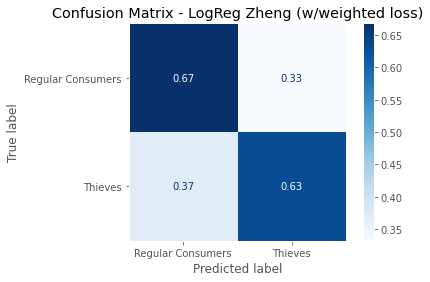

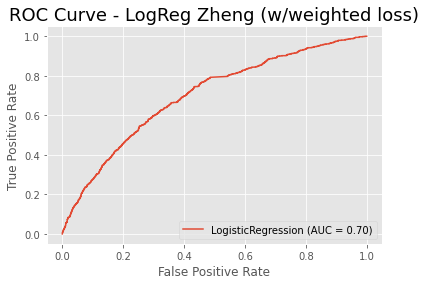

In [23]:
# Did it do any better than the original model?
get_classification_result(estimator=logRegZheng, X=X_test_1D, 
                          y_true=y_test, 
                          classifier_name="LogReg Zheng (w/weighted loss)", 
                          normalize_conf_mat="rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.67      0.78      7752
         Thieves       0.15      0.63      0.24       723

        accuracy                           0.66      8475
       macro avg       0.55      0.65      0.51      8475
    weighted avg       0.88      0.66      0.74      8475

CONFUSION MATRIX
[[0.61109145 0.30359882]
 [0.03150442 0.05380531]]


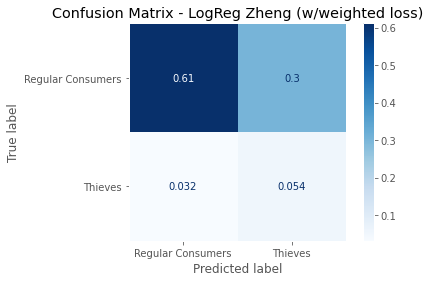

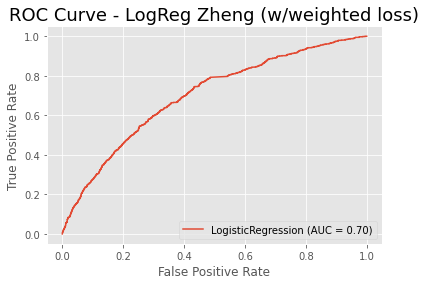

In [24]:
# Did it do any better than the original model?
get_classification_result(estimator=logRegZheng, X=X_test_1D, 
                          y_true=y_test, 
                          classifier_name="LogReg Zheng (w/weighted loss)", 
                          normalize_conf_mat="all")

# How does this compare to the original model?

In [66]:
log_reg_zheng = LogisticRegression(penalty='l2', 
                                   C=1.0, 
                                   max_iter=500, 
                                   solver='liblinear', 
                                   random_state=0, 
                                   verbose=1)

In [67]:
log_reg_zheng.fit(X_train_val_1D, y_train_val)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.34      0.04      0.08       723

        accuracy                           0.91      8475
       macro avg       0.63      0.52      0.51      8475
    weighted avg       0.87      0.91      0.88      8475

CONFUSION MATRIX
[[0.99238906 0.00761094]
 [0.9571231  0.0428769 ]]


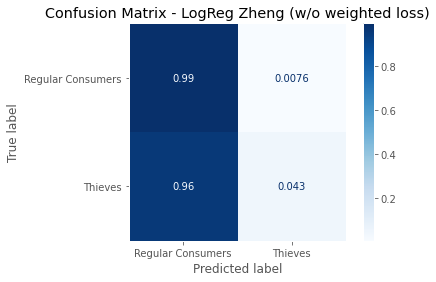

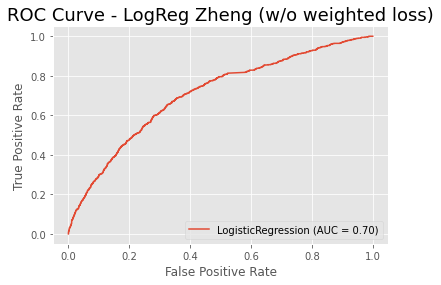

In [71]:
get_classification_result(estimator=log_reg_zheng, 
                          X=X_test_1D, 
                          y_true=y_test, 
                          classifier_name="LogReg Zheng (w/o weighted loss)", 
                          normalize_conf_mat="rows")

# Manual Weights 

In [74]:
class_distribution = df['FLAG'].value_counts()/len(df)

In [75]:
class_distribution

0    0.914684
1    0.085316
Name: FLAG, dtype: float64

In [79]:
class_weights = dict(zip([0, 1], 1 / class_distribution))

In [81]:
class_weights

{0: 1.0932734731790386, 1: 11.721161825726142}

In [82]:
log_reg_manual = LogisticRegression(penalty='l2', 
                                    C=1.0, 
                                    class_weight=class_weights, 
                                    verbose=1, 
                                    solver='liblinear', 
                                    max_iter=500)

In [83]:
log_reg_manual.fit(X_train_val_1D, y_train_val)

[LibLinear]

LogisticRegression(C=1.0,
                   class_weight={0: 1.0932734731790386, 1: 11.721161825726142},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=1, warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.67      0.78      7752
         Thieves       0.15      0.63      0.24       723

        accuracy                           0.66      8475
       macro avg       0.55      0.65      0.51      8475
    weighted avg       0.88      0.66      0.74      8475

CONFUSION MATRIX
[[0.66795666 0.33204334]
 [0.36929461 0.63070539]]


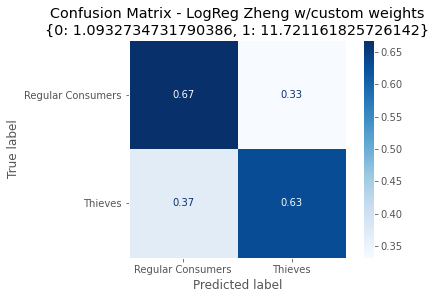

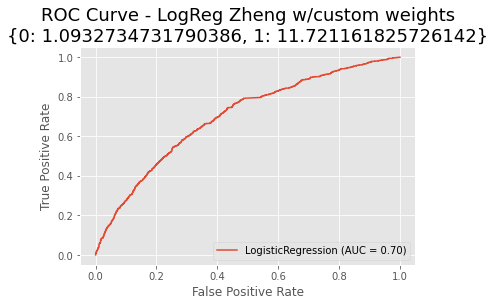

In [86]:
get_classification_result(log_reg_manual, X_test_1D, y_test, 
                          classifier_name="LogReg Zheng w/custom weights\n" + 
                          str(class_weights), normalize_conf_mat="rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.67      0.78      7752
         Thieves       0.15      0.63      0.24       723

        accuracy                           0.66      8475
       macro avg       0.55      0.65      0.51      8475
    weighted avg       0.88      0.66      0.74      8475

CONFUSION MATRIX
[[0.61097345 0.30371681]
 [0.03150442 0.05380531]]


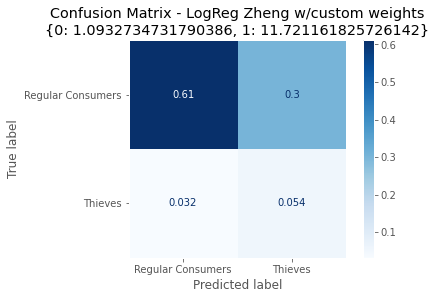

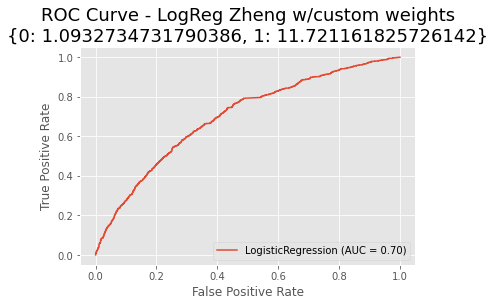

In [87]:
get_classification_result(log_reg_manual, X_test_1D, y_test, 
                          classifier_name="LogReg Zheng w/custom weights\n" + 
                          str(class_weights), normalize_conf_mat="all")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.67      0.78      7752
         Thieves       0.15      0.63      0.24       723

        accuracy                           0.66      8475
       macro avg       0.55      0.65      0.51      8475
    weighted avg       0.88      0.66      0.74      8475

CONFUSION MATRIX
[[0.95096419 0.84950495]
 [0.04903581 0.15049505]]


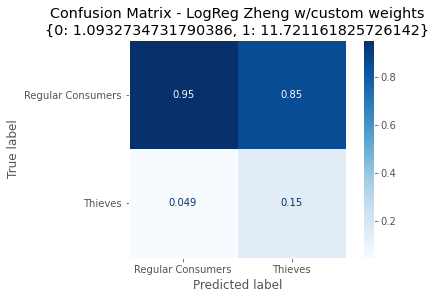

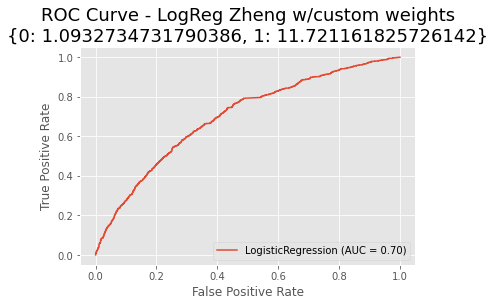

In [88]:
get_classification_result(log_reg_manual, X_test_1D, y_test, 
                          classifier_name="LogReg Zheng w/custom weights\n" + 
                          str(class_weights), normalize_conf_mat="cols")